In [3]:
import pandas as pd
import numpy as np
import os
import sys
import bs4
import tqdm
from pathlib import Path
import shutil
import filecmp
from collections import Counter
import json
import requests
from bs4 import BeautifulSoup
import re

Given are files from a darkweb forum. The data is raw and semi-structured in html format.

Goal, csv File with cols: id, messageId, datetime, isReply, userId, messageContent, replies, links
- threadId: unique identifier for the thread
- messageId: unique identifier for the message within the thread (unique identifier)
- datetime: timestamp of the message
- isReply: boolean indicating if the message is a reply to another message
- userId: unique identifier for the user within the thread
- messageContent: the message content (UTF-8 encoded)
- replies: list of number of replies to this message message
- links: list of links in the message content

Process:
1. Create csv file with the columns: id, messageId, datetime, isReply, userId, messageContent, replies, links
2. Filter for just thread html files.
3. Give the html file to a LLM to extract the data, with a predefined prompt.
4. Append the data to the csv file.

In [4]:
DEFAULT_DIR = Path("../data/")

# Create csv file
# df_path = DEFAULT_DIR / "data.csv"
# if not Path.exists(df_path):
#     cols = ['threadId', 'messageId', 'datetime', 'isReply', 'userId', 'messageContent', 'replies', 'links']
#     df = pd.DataFrame(columns=cols)
#     df.set_index('messageId', inplace=True)
#     df.to_csv(df_path)


In [42]:
class FilenamePreselector:
    ''' Selects the right files to further process by filtering them based on their filename'''
    def __init__(self, root_dir):
        self.root_dir = root_dir
        folders = ["media", "preview", "static", "boards", "other", "threads"]
        self.FOLDERS_PATH = [os.path.join(DEFAULT_DIR, folder) for folder in folders]
        [os.makedirs(folder, exist_ok=True) for folder in self.FOLDERS_PATH] # Create the folders if they don't exist

    # Function to detect if html file is valid by filename
    def is_media(self, filename):
        '''If the filename contains ".png" or ".jpg" or ".jpeg", we consider it as an image'''
        extensions = [".png", ".jpg", ".jpeg", ".gif", "_.media_"]
        if any(ext in filename for ext in extensions):
            return True
        return False

    def is_preview(self, filename):
        '''If the filename contains "_preview_" we consider it as a preview'''
        if "_preview_" in filename:
            return True
        return False

    def is_static(self, filename):
        '''If the filename contains "_.static_" we consider it as a static file'''
        if "_.static_" in filename:
            return True
        return False

    def is_boards(self, filename):
        '''If the filename contains "_boards.js" we consider it as a boards file'''
        if "_boards.js" in filename:
            return True
        return False

    def not_target_url(self, filename):
        '''If the filename does not start with taget url '''
        target_url = "enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion"
        if filename.startswith(target_url):
            return False
        return True
    
    def sort_by_extension(self):
        function_folder_path = [
                (self.is_media, self.FOLDERS_PATH[0]),
                (self.is_preview, self.FOLDERS_PATH[1]),
                (self.is_static, self.FOLDERS_PATH[2]),
                (self.is_boards, self.FOLDERS_PATH[3]),
                (self.not_target_url, self.FOLDERS_PATH[4]),
                (lambda x: True, self.FOLDERS_PATH[5]), # Default case for other files
        ]
        files_per_folders = Counter(
            {folder_path: 0 for _, folder_path in function_folder_path} # Initialize the counter for each folder
        )
        # Loop through all files in the folder, and put them in the right folder use all three functions above for that
        try:
            for filename in tqdm.tqdm([f for f in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, f))]):
                for function, folder_path in function_folder_path:
                    if function(filename):
                        # Copy the file to the right folder
                        source_path = os.path.join(self.root_dir, filename)
                        destination_path = os.path.join(folder_path, filename)
                        #print(source_path, destination_path)
                        # If file already exists, overwrite it
                        shutil.copy(source_path, destination_path)
                        # Increment the counter for the folder
                        files_per_folders[folder_path] += 1
                        # Break the loop once the file is moved
                        break
        except Exception as e:
            print(f"An error occurred: {e}")

        finally:
            return files_per_folders

    def remove_hash(self, filename):
        '''Remove the hash from the filename'''
        if "#" in filename:
            return filename.split("#")[0]
        return filename

    def list_duplicates(self, path):
        '''List all the duplicates (by name) in a folder'''
        files = os.listdir(path)
        duplicates = []
        # Remove the hash from the filename and compare then the filename 
        files = [self.remove_hash(file) for file in files]
        # Count the occurrences of each file name
        file_counts = Counter(files)
        # Find the files that have duplicates
        for file, count in tqdm.tqdm(file_counts.items(), desc="Processing duplicates"):
            if count > 1:
                duplicates.append(file)
        return duplicates
    
    def remove_duplicates(self, duplicates, path):
        ''' Deletes the duplicates in a folder'''
        #+ duplicates = [filename, filename, filename] # without the hash
        #+ path = "/path/to/folder"
        removed_files = []
        for file in duplicates:
            # Delete the first occurence of the file within the path, careful the duplicates list value is not the same as the file name, but its the starting part of the file name
            for existing_file in os.listdir(path):
                if existing_file.startswith(file):
                    os.remove(os.path.join(path, existing_file))
                    removed_files.append(existing_file)
                    break
        return removed_files

preselector = FilenamePreselector(DEFAULT_DIR)
files_splitted_in_folders = preselector.sort_by_extension()
# Get keys from the Counter object
folders_path = list(files_splitted_in_folders.keys())
print(f"Folders Path: {folders_path}")

for folder_path in folders_path:
    print(f"Folder: {folder_path}")
    print(f"Number of files: {files_splitted_in_folders[folder_path]}")
    # List duplicates in the folder
    duplicates = preselector.list_duplicates(folder_path)
    print(f"number Duplicates: {len(duplicates)}")
    print(f"Duplicates: {duplicates}")

    # Remove duplicates in the folder
    removed_files = preselector.remove_duplicates(duplicates, folder_path)
    print(f"Removed files: {removed_files}")
    print(f"Number of files after removing duplicates: {len(os.listdir(folder_path))}")
            

100%|██████████| 7118/7118 [00:13<00:00, 520.82it/s]


Folders Path: ['../data/media', '../data/preview', '../data/static', '../data/boards', '../data/other', '../data/threads']
Folder: ../data/media
Number of files: 1194


Processing duplicates: 100%|██████████| 1194/1194 [00:00<00:00, 9395870.50it/s]


number Duplicates: 0
Duplicates: []
Removed files: []
Number of files after removing duplicates: 1194
Folder: ../data/preview
Number of files: 1706


Processing duplicates: 100%|██████████| 1706/1706 [00:00<00:00, 10207535.84it/s]


number Duplicates: 0
Duplicates: []
Removed files: []
Number of files after removing duplicates: 1706
Folder: ../data/static
Number of files: 41


Processing duplicates: 100%|██████████| 41/41 [00:00<00:00, 1637775.85it/s]


number Duplicates: 0
Duplicates: []
Removed files: []
Number of files after removing duplicates: 41
Folder: ../data/boards
Number of files: 161


Processing duplicates: 100%|██████████| 161/161 [00:00<00:00, 5535106.10it/s]


number Duplicates: 0
Duplicates: []
Removed files: []
Number of files after removing duplicates: 161
Folder: ../data/other
Number of files: 46


Processing duplicates: 100%|██████████| 45/45 [00:00<00:00, 2359296.00it/s]


number Duplicates: 1
Duplicates: ['hctxrvjzfpvmzh2jllqhgvvkoepxb4kfzdjm6h7egcwlumggtktiftid.onion_rs.html']
Removed files: ['hctxrvjzfpvmzh2jllqhgvvkoepxb4kfzdjm6h7egcwlumggtktiftid.onion_rs.html#search.html']
Number of files after removing duplicates: 45
Folder: ../data/threads
Number of files: 3970


Processing duplicates: 100%|██████████| 187/187 [00:00<00:00, 5335611.21it/s]


number Duplicates: 76
Duplicates: ['enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_56237.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_19890.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_24483.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_23563.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_15758.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_34921.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_25260.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_agatha2_res_116498.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_agatha2_res_131387.html', 'enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjwmbpj5smdad.onion_qanonresearch_res_960.html', 'enxx3byspwsdo446jujc52ucy2

In [ ]:
class AmbassadorLLM:
    ''' 
    Talks with the LLM 
    - Establishes connections
    - Sends prompt
    - Makes sure the returned answer is in the right format
    '''
    def __init__(self, body):
        self.url = "http://localhost:11434/api/generate"
        self.body = body # {model, prompt, stream}
    
    def ask(self, prompt, attached_file):
        self.body['prompt'] = self.merge_prompt(prompt, attached_file)
        response = requests.post(
            self.url,
            json=self.body
        )
        if response.status_code != 200:
            # Throw an error if the response status code is not 200
            raise Exception(f"Error: Received status code {response.status_code} from LLM API")
        else:
            data = json.loads(response.text)
            return data
    
    def merge_prompt(self, prompt, attached_file):
        with open(attached_file, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')
        cleaned_file_content = self.clean_text(soup.get_text())
        return f"{prompt}\n\n{"Here the html file:"}\n{cleaned_file_content}"
    
    def clean_text(self, text):
        # Remove non-alphanumeric characters (except spaces)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Replace multiple spaces and newlines with a single space
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def verify_prompt_answer_format(value):
        if isinstance(value, dict):
            return True
        return False

body = {
    "model": "deepseek-r1:1.5b",
    "prompt": "",
    "stream": False
}
path = folder_path[5] # should be Threads
prompt = "Extract the required data from the HTML file."
deepseek = AmbassadorLLM(body)

# Loop through all files in the specified folder path
for file in tqdm(os.listdir(path), desc="Processing files"):
    file_path = os.path.join(path, file)
    if os.path.isfile(file_path):
        try:
            # Call the deepseek.ask() function with a prompt and the file path
            result = deepseek.ask(prompt, file_path)
            # Process the result (e.g., append to a DataFrame or save to a file)
            # Assuming result is a dictionary matching the DataFrame columns
            with open(df_path, "a", encoding="utf-8") as f:
                f.write(pd.DataFrame([result]).to_csv(header=False, index=False))
        except Exception as e:
            print(f"Error processing file {file}: {e}")

# Save the updated DataFrame to the CSV file
df.to_csv(DEFAULT_DIR / "data.csv", index=False)

In [ ]:
# Move all files recursivle from the folders within the DEFAULT_DIR to the DEFAULT_DIR
for folder in folders:
    folder_path = os.path.join(DEFAULT_DIR, folder)
    for filename in os.listdir(folder_path):
        source_path = os.path.join(folder_path, filename)
        destination_path = os.path.join(DEFAULT_DIR, filename)
        # If file already exists, overwrite it
        shutil.move(source_path, destination_path)

In [22]:
# Delete all folders within the DEFAULT_DIR
for folder in folders:
    folder_path = os.path.join(DEFAULT_DIR, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder does not exist: {folder_path}")

Deleted folder: ../data/media
Deleted folder: ../data/preview
Deleted folder: ../data/static
Deleted folder: ../data/boards
Deleted folder: ../data/other
Deleted folder: ../data/threads


In [28]:
# read file
format = {
    "threadId": str,
    "messageId": str,
    "messageContent": str,
}
path = os.path.join(DEFAULT_DIR, "data.csv")
df = pd.read_csv(path, dtype=format, parse_dates=["datetime"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306543 entries, 0 to 2306542
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   originFile      object        
 1   messageId       object        
 2   threadId        object        
 3   datetime        datetime64[ns]
 4   messageContent  object        
 5   summary         object        
dtypes: datetime64[ns](1), object(5)
memory usage: 105.6+ MB
None


In [29]:
df.describe(include='all')

,originFile,messageId,threadId,datetime,messageContent,summary
count,2306543,2306543,2306543,2035524,2108638,2108638
unique,3865,33296,46,NaN,30995,1
top,enxx3byspwsdo446jujc52ucy2pf5urdbhqw3kbsfhlfjw...,25551,qanonresearch,NaN,>>25701,Summary of the messageContent
freq,798,705,2263694,NaN,2088,2108638
mean,NaN,NaN,NaN,2019-10-27 11:40:46.091364352,NaN,NaN
min,NaN,NaN,NaN,2016-01-09 05:25:26,NaN,NaN
25%,NaN,NaN,NaN,2019-10-25 07:27:08,NaN,NaN
50%,NaN,NaN,NaN,2019-10-26 22:17:47,NaN,NaN
75%,NaN,NaN,NaN,2019-10-28 03:29:14,NaN,NaN
max,NaN,NaN,NaN,2022-08-07 04:17:52,NaN,NaN


In [30]:
# Null values
df.isnull().sum()

originFile             0
messageId              0
threadId               0
datetime          271019
messageContent    197905
summary           197905
dtype: int64

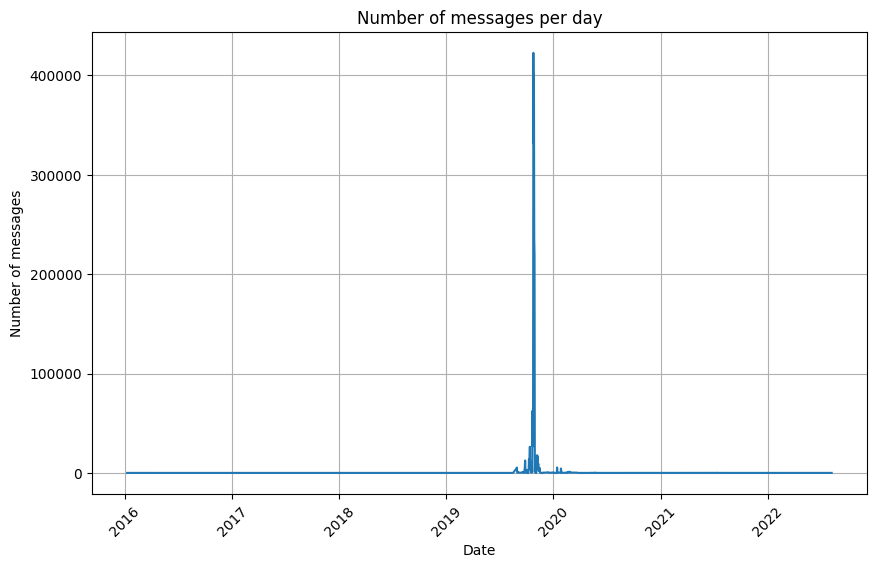

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime examine how many messages per day
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['date'] = df['datetime'].dt.date
df['date'] = pd.to_datetime(df['date'])
# Count the number of messages per day
messages_per_day = df['date'].value_counts().sort_index()
# Plot the number of messages per day
plt.figure(figsize=(10, 6))
plt.plot(messages_per_day.index, messages_per_day.values)
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.title('Number of messages per day')
plt.xticks(rotation=45)
plt.grid()
plt.show()

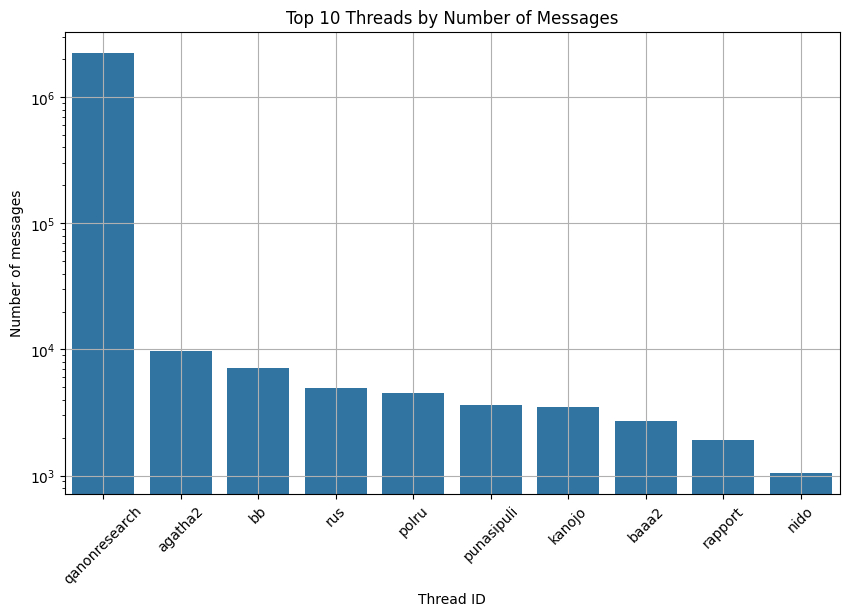

In [ ]:
# Count the number of messages per thread and sort in descending order
thread_message_counts = df['threadId'].value_counts().sort_values(ascending=False).head(10)

# Plot the top 10 threads by number of messages
plt.figure(figsize=(10, 6))
sns.barplot(x=thread_message_counts.index, y=thread_message_counts.values)
plt.xlabel('Thread ID')
plt.ylabel('Number of messages')
plt.title('Top 10 Threads by Number of Messages')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.grid()
plt.show()
